In [1]:
import os
import time
from tqdm import tqdm

import pyproj
import shapely

import gmaps
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set up API Authentication.
key_path = "/Users/administrator/Documents/Projects/abq_crime/api_key.txt"
with open(key_path) as f:
    api_key = f.readline()
    f.close()

gmaps.configure(api_key=api_key)

In [3]:
shapefile_path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/PdDistricts"
districts_dataframe = gpd.read_file(shapefile_path)
districts_dataframe = districts_dataframe[["district", "geometry"]]

Some of the districts are defined by MultiPolygons. Let's split them.

In [4]:
# Extract the indices of the districts whose geometry is a multipolygon.
mpolygon_indices = [type(item) == shapely.geometry.multipolygon.MultiPolygon for item in districts_dataframe["geometry"]]
mpolygon_indices = [idx for idx, item in enumerate(mpolygon_indices) if item == True]

In [5]:
# For those entries, split up the polygons.
new_entries = list()
for index in mpolygon_indices:
    district = districts_dataframe.iloc[index]["district"]
    for poly in districts_dataframe.iloc[index]["geometry"]:
        new_entries.append((district, poly))

In [6]:
# Add entries to the DataFrame.
for entry in new_entries:
    districts_dataframe.loc[len(districts_dataframe)] = entry

# Delete the original entries.
districts_dataframe.drop(mpolygon_indices, axis=0, inplace=True)
districts_dataframe.reset_index(drop=True, inplace=True)

In [7]:
# Create a list of Polygon coordinates to plot using Google Maps API.
districts_polygon_coords = [districts_dataframe["geometry"][idx].exterior.coords[:] for idx in range(len(districts_dataframe))]

# The list of coordinates are in (longitude, latitude) but we need them in (latitude, longitude).
for idx_poly, poly in enumerate(districts_polygon_coords):
    for idx_coord, coord in enumerate(poly):
        districts_polygon_coords[idx_poly][idx_coord] = coord[::-1]

In [8]:
# Set up the drawing list.
drawing_list = list()
for idx, polygon_coords in enumerate(districts_polygon_coords):
    drawing_list.append(gmaps.Polygon(polygon_coords, stroke_color="black", stroke_opacity=0.2,))

In [9]:
# Plot the Polygons using the Google Maps API.
fig = gmaps.figure()
drawing = gmaps.drawing_layer(features=drawing_list, show_controls=False,)
fig.add_layer(drawing)
fig

Figure(layout=FigureLayout(height='420px'))

Now let's deal with that single missing entry in the Police District.

In [10]:
import numpy as np
import pandas as pd

In [11]:
path = "/Users/administrator/Documents/Projects/sf-crime-exploration/data/SFPD_Crime_Data_2003_2018.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[["PdDistrict", "Y", "X"]]

In [21]:
entry = dataframe[dataframe.PdDistrict.isna()].iloc[0]
coordinates = (round(entry[2], 5), round(entry[1], 5))
coordinates = shapely.geometry.Point(coordinates)
print(coordinates.xy)

(array('d', [-122.41335]), array('d', [37.7082]))


In [22]:
# Create a list of shapely Polygon objects to find districts.
districts_shapely_polygons = districts_dataframe["geometry"]
districts_shapely_polygons = list(districts_shapely_polygons)

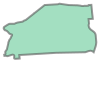

In [23]:
districts_shapely_polygons[1]

In [24]:
# Find which district it belongs to.
for idx, poly in enumerate(districts_shapely_polygons):
    if poly.contains(coordinates):
        print(idx)

For some reason, the above is not working.

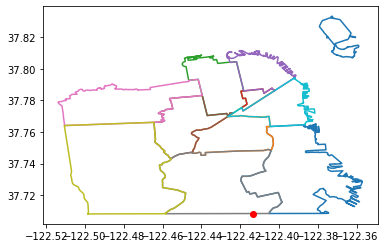

In [25]:
# Use matplotlib to plot the data points to see what is going on.
for idx in range(len(districts_shapely_polygons)):
    plt.plot(*districts_shapely_polygons[idx].exterior.xy)
plt.plot(*coordinates.xy, "ro")

Maybe the point is actually outside of San Francisco county. Check with the bounding box.

In [26]:
x = coordinates.xy[0][0]
y = coordinates.xy[1][0]

if (x >= -123.173825 and x <= -122.28178) and (y >= 37.623983 and y <= 37.929824):
    print("Valid")
else:
    print("Invalid")

Valid


Weird, it says that the coordinate is a valid coordinate.

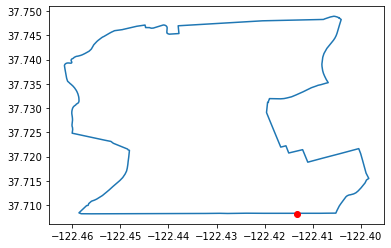

In [27]:
plt.plot(*districts_shapely_polygons[7].exterior.xy)
plt.plot(*coordinates.xy, "ro")

In [28]:
districts_shapely_polygons[7].bounds

(-122.46164405989353, 37.70821595689006, -122.3983249824636, 37.74891461201384)

In [29]:
coordinates.xy

(array('d', [-122.41335]), array('d', [37.7082]))

Oh well, it looks like that it is in San Francisco county but it is not contained in the Polygons and borders it just a little bit.

This is just one data point, we may have better luck with the second dataset.